In [1]:
import numpy as np
import random
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
mnist=fetch_openml('mnist_784',version=1,parser='auto')
X=mnist.data.astype('float32')

In [3]:
y=mnist.target.astype('int')

In [4]:
mask = (y == 0) | (y == 1)
X = X[mask]
y = y[mask]

In [5]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Class distribution: {np.bincount(y)}")

X shape: (14780, 784)
y shape: (14780,)
Class distribution: [6903 7877]


In [6]:
X_class0 = X[y == 0]
X_class1 = X[y == 1]
y_class0 = y[y == 0]
y_class1 = y[y == 1]


In [7]:
indices_class0 = np.random.choice(X_class0.shape[0], size=1000, replace=False)
indices_class1 = np.random.choice(X_class1.shape[0], size=1000, replace=False)

In [8]:
X_train = np.vstack((X_class0.iloc[indices_class0].values, X_class1.iloc[indices_class1].values))
y_train = np.hstack((y_class0.iloc[indices_class0].values, y_class1.iloc[indices_class1].values))

In [9]:
mask_test_class0 = np.ones(X_class0.shape[0], dtype=bool)
mask_test_class0[indices_class0] = False
mask_test_class1 = np.ones(X_class1.shape[0], dtype=bool)
mask_test_class1[indices_class1] = False


In [10]:
X_test = np.vstack((X_class0[mask_test_class0], X_class1[mask_test_class1]))
y_test = np.hstack((y_class0[mask_test_class0], y_class1[mask_test_class1]))

In [11]:
pca = PCA(n_components=5)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [12]:
print(f"Training shape: {X_train_pca.shape}")
print(f"Testing shape: {X_test_pca.shape}")

Training shape: (2000, 5)
Testing shape: (12780, 5)


In [13]:
class DecisionStump:
  def __init__(self):
    self.polarity = 1
    self.feature_idx = None
    self.threshold = None
    self.min_error=float('inf')
    self.predictions=None

  def fit(self,X,y,sample_weights):
    n_samples,n_features=X.shape
    self.min_error=float('inf')

    for feature_idx in range(n_features):

      feature_min = np.min(X[:, feature_idx])
      feature_max = np.max(X[:, feature_idx])


      thresholds = np.linspace(feature_min, feature_max, 4)[1:-1]

      for threshold in thresholds:
        for polarity in [1, -1]:

          predictions = np.ones(n_samples)
          if polarity ==1:
            predictions[X[:,feature_idx]<threshold]=0
          else:
            predictions[X[:, feature_idx] >= threshold] = 0

          misclassified=predictions!=y
          weighted_error = np.sum(sample_weights[misclassified])

          if weighted_error < self.min_error:
              self.min_error = weighted_error
              self.feature_idx = feature_idx
              self.threshold = threshold
              self.polarity = polarity
              self.predictions = predictions

  def predict(self,X):
    n_samples = X.shape[0]
    predictions = np.ones(n_samples)

    if self.polarity==1:
        predictions[X[:, self.feature_idx] < self.threshold] = 0
    else:
        predictions[X[:, self.feature_idx] >= self.threshold] = 0

    return predictions

In [14]:
def loss_calc_weighted_01(y_true, y_pred, sample_weights):
    incorrect = y_true != y_pred
    return np.sum(sample_weights[incorrect])


In [15]:
def predict_adaboost(models_tray, alphas, X):
    combined_scores = np.zeros(X.shape[0])
    for stump, alpha in zip(models_tray, alphas):
        stump_preds = stump.predict(X)
        combined_scores += alpha * (2 * stump_preds - 1)  # map {0,1} -> {-1,1}

    preds = 0.5 * (np.sign(combined_scores) + 1)
    return preds

In [22]:
class AdaBoostScratch:
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.stumps = []
        self.alphas = []
        self.train_errors = []
        self.test_errors = []

    def _map_labels(self, y):

        return np.where(y == 0, -1, 1)

    def fit(self, X_train, y_train, X_test=None, y_test=None):
        y_train_mapped = self._map_labels(y_train)
        if y_test is not None:
            y_test_mapped = self._map_labels(y_test)

        n_samples = X_train.shape[0]
        sample_weights = np.ones(n_samples) / n_samples
        pred_train_sum = np.zeros(n_samples)
        pred_test_sum = np.zeros(len(X_test)) if X_test is not None else None

        for i in range(self.n_estimators):
            stump = DecisionStump()
            stump.fit(X_train, (y_train_mapped + 1) // 2, sample_weights)
            pred_stump = stump.predict(X_train)
            pred_stump_mapped = np.where(pred_stump == 0, -1, 1)

            err = np.sum(sample_weights[pred_stump_mapped != y_train_mapped]) / np.sum(sample_weights)
            err = max(err, 1e-10)

            alpha = 0.5 * np.log((1 - err) / err)


            sample_weights *= np.exp(-alpha * y_train_mapped * pred_stump_mapped)
            sample_weights /= np.sum(sample_weights)


            self.stumps.append(stump)
            self.alphas.append(alpha)


            pred_train_sum += alpha * pred_stump_mapped
            train_preds = self.predict(X_train)
            train_error = np.mean(train_preds != (y_train_mapped + 1) // 2)  # convert back to 0/1
            self.train_errors.append(train_error)


            if X_test is not None:
                test_preds = self.predict(X_test)
                test_error = np.mean(test_preds != (y_test_mapped + 1) // 2)
                self.test_errors.append(test_error)



    def predict(self, X):
        agg_pred = np.zeros(X.shape[0])
        for stump, alpha in zip(self.stumps, self.alphas):
            pred = stump.predict(X)
            pred_mapped = np.where(pred == 0, -1, 1)
            agg_pred += alpha * pred_mapped
        return np.where(agg_pred >= 0, 1, 0)


In [19]:
def plot_error_rate(train_errors, test_errors=None):
    plt.figure(figsize=(10, 6))
    plt.plot(train_errors, label='Train Error', color='dodgerblue')
    if test_errors is not None:
        plt.plot(test_errors, label='Test Error', color='darkorange')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Error Rate')
    plt.title('AdaBoost Error Rate vs Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()


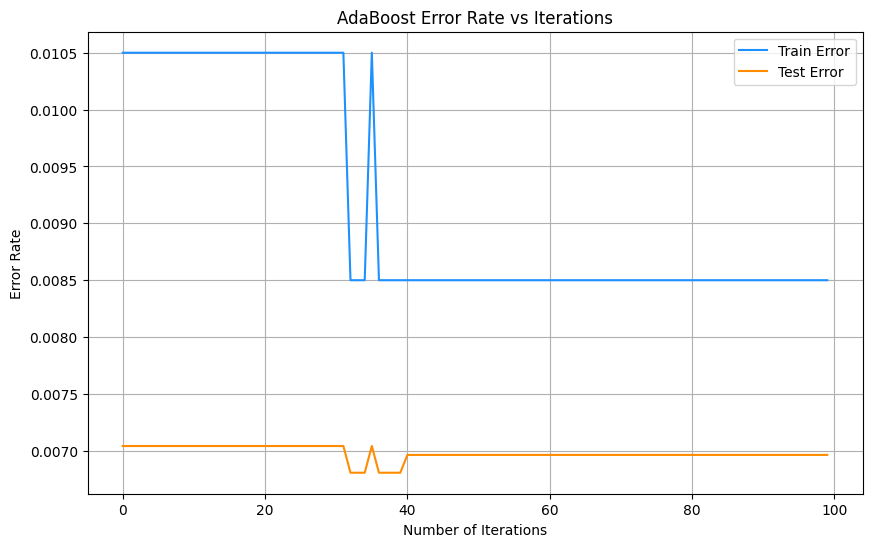

In [24]:
n_estimators=100
adaboost=AdaBoostScratch(n_estimators=n_estimators)
adaboost.fit(X_train_pca, y_train, X_test_pca, y_test)
plot_error_rate(adaboost.train_errors, adaboost.test_errors)

In [25]:
y_preds=adaboost.predict(X_test_pca)
accuracy=np.mean(y_preds==y_test)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9930359937402191
